# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MNIST Dataset


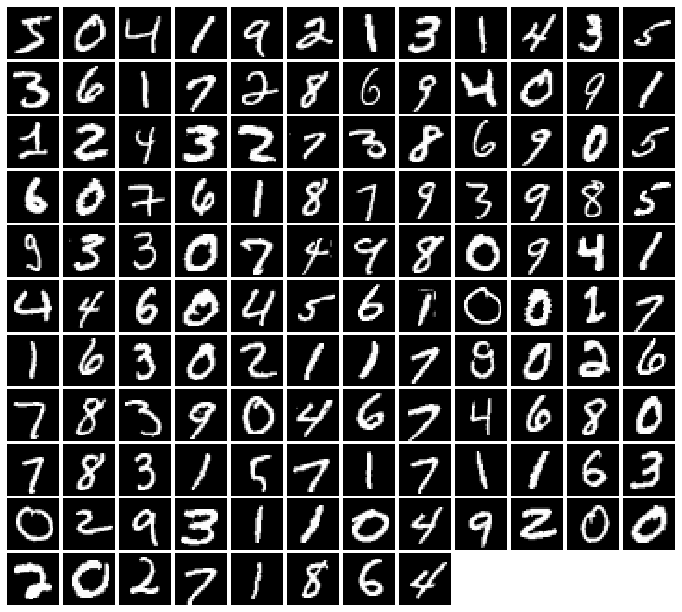

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.384, G:0.6919


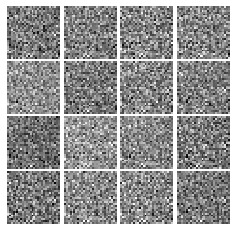


Iter: 250, D: 0.7945, G:0.7605


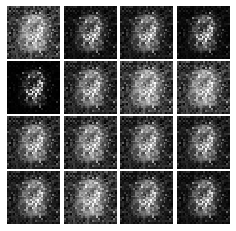


EPOCH:  2
Iter: 500, D: 1.206, G:1.081


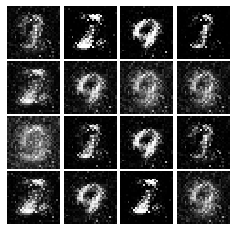


Iter: 750, D: 1.451, G:1.397


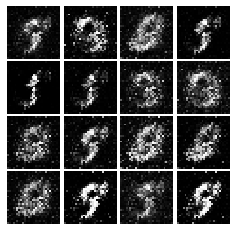


EPOCH:  3
Iter: 1000, D: 0.9886, G:2.132


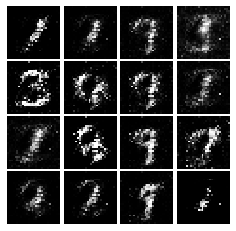


Iter: 1250, D: 1.209, G:1.035


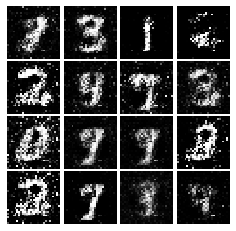


EPOCH:  4
Iter: 1500, D: 1.073, G:1.774


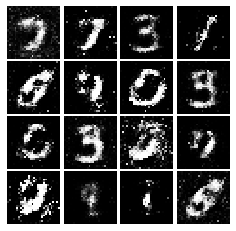


Iter: 1750, D: 1.326, G:0.9868


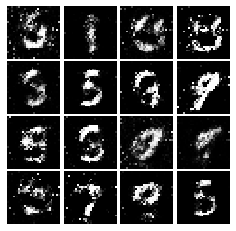


EPOCH:  5
Iter: 2000, D: 1.278, G:1.062


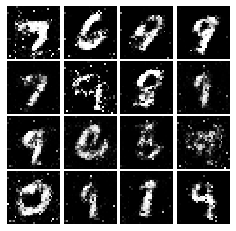


Iter: 2250, D: 1.213, G:0.9419


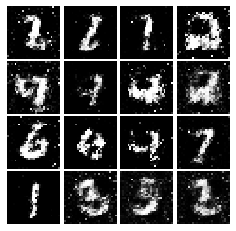


EPOCH:  6
Iter: 2500, D: 1.293, G:0.9558


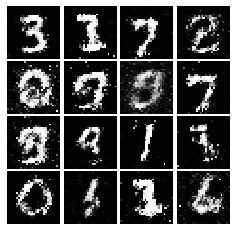


Iter: 2750, D: 1.269, G:0.8829


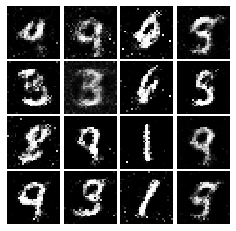


EPOCH:  7
Iter: 3000, D: 1.192, G:0.8541


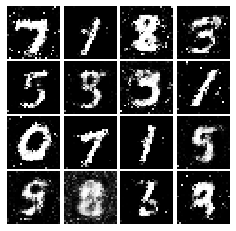


Iter: 3250, D: 1.235, G:1.021


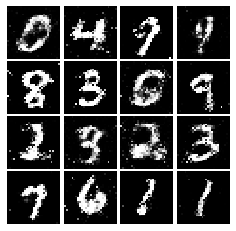


EPOCH:  8
Iter: 3500, D: 1.255, G:0.8952


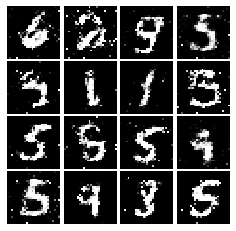


EPOCH:  9
Iter: 3750, D: 1.284, G:0.8431


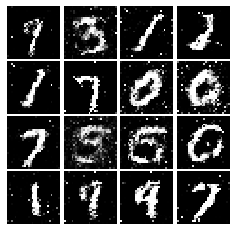


Iter: 4000, D: 1.354, G:0.9386


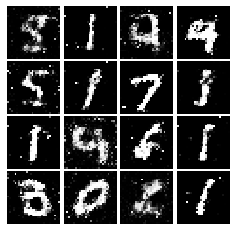


EPOCH:  10
Iter: 4250, D: 1.306, G:0.8394


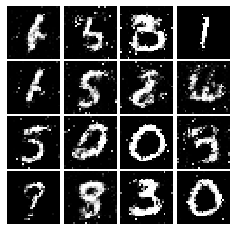


Iter: 4500, D: 1.334, G:0.7893


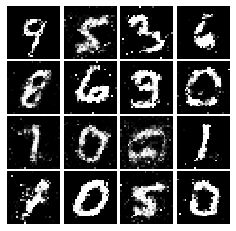

In [12]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5289, G:0.4614


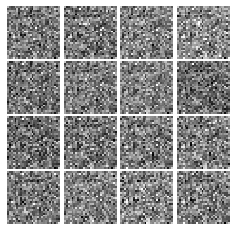


Iter: 250, D: 0.09014, G:0.4054


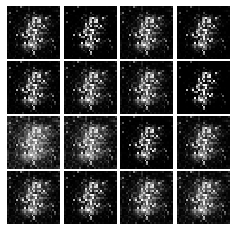


EPOCH:  2
Iter: 500, D: 0.1598, G:0.2953


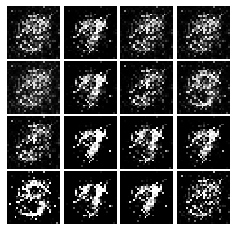


Iter: 750, D: 0.1556, G:0.7765


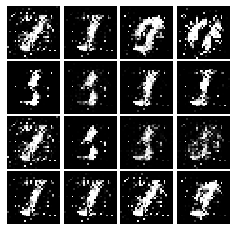


EPOCH:  3
Iter: 1000, D: 0.1838, G:0.2509


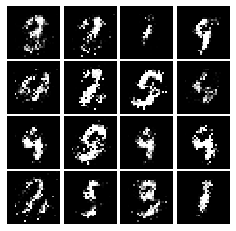


Iter: 1250, D: 0.2123, G:0.2407



EPOCH:  4
Iter: 1500, D: 0.2401, G:0.249


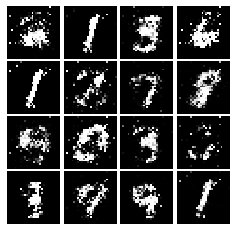


Iter: 1750, D: 0.2011, G:0.2051


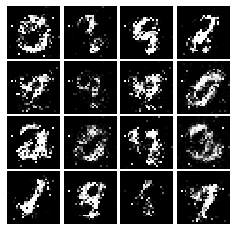


EPOCH:  5
Iter: 2000, D: 0.2092, G:0.1817


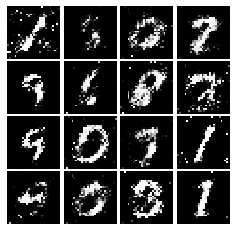


Iter: 2250, D: 0.1932, G:0.1866


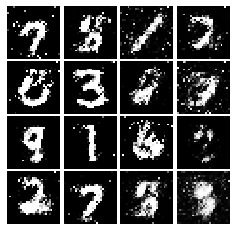


EPOCH:  6
Iter: 2500, D: 0.232, G:0.1934


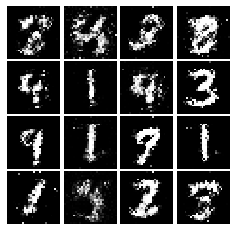


Iter: 2750, D: 0.2396, G:0.1921


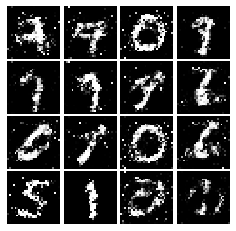


EPOCH:  7
Iter: 3000, D: 0.2093, G:0.1631


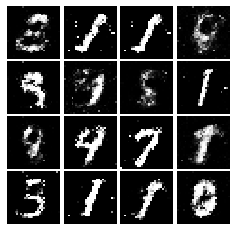


Iter: 3250, D: 0.2023, G:0.1768


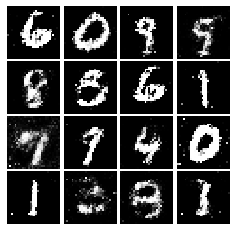


EPOCH:  8
Iter: 3500, D: 0.2337, G:0.1497


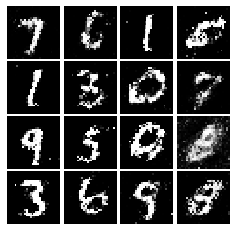


EPOCH:  9
Iter: 3750, D: 0.2299, G:0.1453


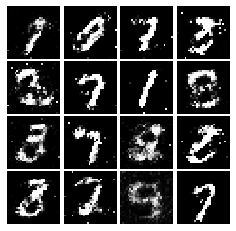


Iter: 4000, D: 0.2349, G:0.1458


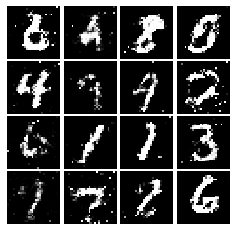


EPOCH:  10
Iter: 4250, D: 0.2207, G:0.1726


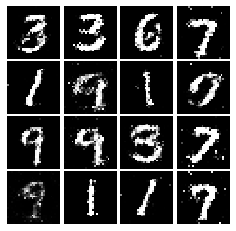


Iter: 4500, D: 0.2172, G:0.1847


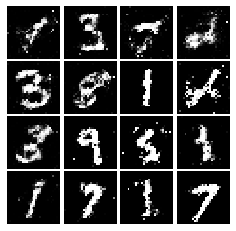

In [13]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)